In [542]:
import numpy as np 
import random as rd
from collections import namedtuple
import matplotlib.pyplot as plt 
card = namedtuple('card', 'name value roller reshuffle condition')

class Deck: 
    def __init__(self, base_attack=3): 
        self.base_attack = base_attack
        self.__default_cards()
        self._create_deck()
        
    def __default_cards(self): 
        self.card_instances = dict(zip(['miss', 'crit', '-2', '-1', '0', '1', '2'],[1, 1, 1, 5, 6, 5, 1]))
        
        self.card_types = {}
        self.card_types['miss'] = {'name': 'miss', 'value': lambda attack_value: -attack_value, 'roller': False, 'reshuffle':True, 'condition':None}
        self.card_types['crit'] = {'name': 'crit', 'value': lambda attack_value: +attack_value, 'roller': False, 'reshuffle':True, 'condition':None}  
        for i in range(-2,3): 
            self.card_types['{}'.format(i)] = {'name': str(i), 'value': i, 'roller': False, 'reshuffle':False, 'condition':None} 
        
        self.n_cards = np.array(list(self.card_instances.values())).sum()
    
    def add_cardtype(self, name, value, roller=False, reshuffle=False, condition=None):
        self.card_types[name] = {'name': name, 'value': value, 'roller': roller, 'reshuffle': reshuffle, 'condition': condition}
        self.card_instances[name] = 1
        
    def _add_card(self, name, value, roller=False, reshuffle=False, condition=None): 
        return card(name, value, roller, reshuffle, condition)    
    
    def _create_deck(self): 
        self.deck = []
        for name, function in self.card_types.items(): 
            for _ in range(self.card_instances[name]):
                self.deck.append( self._add_card(**function) )
        self.n_cards = np.array(list(self.card_instances.values())).sum()
    
    def create_perks(self, perk_names): 
        perks = []
        
        for p in perk_names: 
            p = p.split(' ')
            remove_perk = lambda action, number, card: perk(action, number, card, repcard=None)
            replace_perk = lambda action, number, card, repcard: perk(action, number, card, repcard=repcard)
            add_perk = lambda action, number, card: perk(action, number, card, repcard=None)
            if p[0] == 'rem':
                perks.append(remove_perk(*p))
            if p[0] == 'rep':
                perks.append(replace_perk(*p))
            if p[0] == 'add':
                perks.append(add_perk(*p))
            if p[0] == 'add2':
                perks.append(add_perk(*p))
        return perks
    
    def add_perk(self, perk):   
            if perk.action == 'rem':
                self.card_instances[perk.card] -= int(perk.number)
                self._create_deck()
            elif perk.action == 'rep': 
                self.card_instances[perk.card] -= int(perk.number)
                self.card_instances[perk.repcard] += int(perk.number)
                self._create_deck()
            elif perk.action == 'add': 
                self.card_instances[perk.card] += int(perk.number)
                self._create_deck()
            elif perk.action == 'add2': 
                card1, card2 = perk.card.split('_')
                self.card_instances[card1] += int(perk.number)
                self.card_instances[card2] += int(perk.number)
                self._create_deck()
    
    def add_bless(self, n_bless): 
        print('{} bless card(s) added'.format(n_bless))
        if 'bless' in self.card_types.keys(): 
            self.card_instances['bless'] += n_bless
        else: 
            self.add_cardtype('bless', lambda attack_value: +attack_value, roller=False, reshuffle=False, condition=None)
            self.card_instances['bless'] += n_bless-1
        self._create_deck()
    
    def draw(self, turns=1): 
        sample = []
        turn = []
        while len(sample) < turns: 
            _ = rd.sample(self.deck, self.n_cards)
            #print([i.value for i in _])
            for card in _:
                turn.append(card)
                if card.roller: 
                    continue
                sample.append(turn)
                if len(sample) == turns: 
                    return sample
                turn = []
                if card.reshuffle: 
                    break
        return sample
        

In [567]:
perk = namedtuple('perk', 'action number card repcard')



class Scoundrel(Deck): 
    def __init__(self, base_attack=3):
        super().__init__(base_attack)
        self.add_scoundrel_cards()
        self.perks = self.create_perks()
        self.added_perks = []
    
    def create_perks(self): 
        perk_names = [
        'rem 2 -1',
        'rem 2 -1',
        'rem 4 0',
        'rep 1 -2 0',
        'rep 1 -1 1',
        'rep 1 0 2',
        'rep 1 0 2',
        'add 2 1roller',
        'add 2 1roller',
        'add 2 pierce3',    
        'add 2 poison',
        'add 2 poison',
        'add 2 muddle',
        'add 1 invisible',
        ]
        
        return super().create_perks(perk_names)
    
    def add_scoundrel_cards(self):
        super().add_cardtype('1roller',1 , roller=True, reshuffle=False, condition=None)
        self.card_instances['1roller'] -= 1
        for cond in ['pierce3', 'poison', 'muddle']:
            super().add_cardtype(cond,0 , roller=True, reshuffle=False, condition=cond)
            self.card_instances[cond] -= 1
        
        super().add_cardtype('invisible',0 , roller=True, reshuffle=False, condition=None)
        self.card_instances['invisible'] -= 1
    
    def add_perk(self, numbers, verbose=False):
        for number in numbers:
            if number in self.added_perks: 
                print('Perk already added')
                print('Perks added so far:')
                [print(self.perks[p]) for p in self.added_perks]
            else:
                if verbose:
                    print(self.perks[number])
                self.added_perks.append(number)
            
            p = self.perks[number]    
            super().add_perk(p)

    def add_bless(self, n_bless):
        return super().add_bless(n_bless)
    
    def draw(self, turns):
        return super().draw(turns)
    
    
class Brute(Deck): 
    def __init__(self, base_attack=3):
        super().__init__(base_attack)
        self.add_brute_cards()
        self.perks = self.create_perks()
        self.added_perks = []
    
    def create_perks(self): 
        perk_names = [
        'rem 2 -1',
        'rem 2 -1',
        'rep 1 -1 1',
        'add 2 1',
        'add 2 1',
        'add 1 3',
        'add 3 push1',
        'add 3 push1',
        'add 2 pierce3',
        'add 1 stun',
        'add 1 stun',            
        'add2 1 disarm_muddle',
        'add 1 add_target',
        'add 1 add_target',            
        'add 1 shield1',
        'rem 4 0'    
        ]
        
        return super().create_perks(perk_names)
    
    def add_brute_cards(self):
        super().add_cardtype('3',3 , roller=False, reshuffle=False, condition=None)
        self.card_instances['3'] -= 1
        for cond in ['pierce3', 'push1', 'stun', 'add_target', 'disarm', 'muddle']:
            super().add_cardtype(cond,0 , roller=True, reshuffle=False, condition=cond)
            self.card_instances[cond] -= 1
        super().add_cardtype('shield1',0 , roller=False, reshuffle=False, condition='shield1')
        self.card_instances['shield1'] -= 1
    
    
    def add_perk(self, numbers, verbose=False):
        for number in numbers:
            if number in self.added_perks: 
                print('Perk already added')
                print('Perks added so far:')
                [print(self.perks[p]) for p in self.added_perks]
            else:
                if verbose:
                    print(self.perks[number])
                self.added_perks.append(number)
            
            p = self.perks[number]    
            super().add_perk(p)

    def add_bless(self, n_bless):
        return super().add_bless(n_bless)
    
    def draw(self, turns):
        return super().draw(turns)


def get_shuffled(sample):
    shuffle = dict()
    for i, turn in enumerate(sample): 
        if turn[-1].reshuffle: 
            shuffle[i] = turn[-1].value
    return shuffle

def get_values(sample, base_attack): 
    attacks =[]
    for turn in sample: 
        attackvalue = base_attack
        for card in turn: 
            if card.name in ['miss', 'crit', 'bless', 'curse']: 
                attackvalue += card.value(attackvalue)
            else: 
                attackvalue += card.value
        attacks.append(attackvalue)
    return attacks

def get_turnlength(sample): 
    return [len(turn) for turn in sample]

# Scoundrel

{'miss': 1,
 'crit': 1,
 '-2': 0,
 '-1': 0,
 '0': 1,
 '1': 6,
 '2': 3,
 '1roller': 4,
 'pierce3': 2,
 'poison': 4,
 'muddle': 2,
 'invisible': 1}

Perk(s): [13]
mean: 6.2
variance: 7.5
Expected turns until reshuffle: 4.3
Expected modifier cards per turn: 2.0



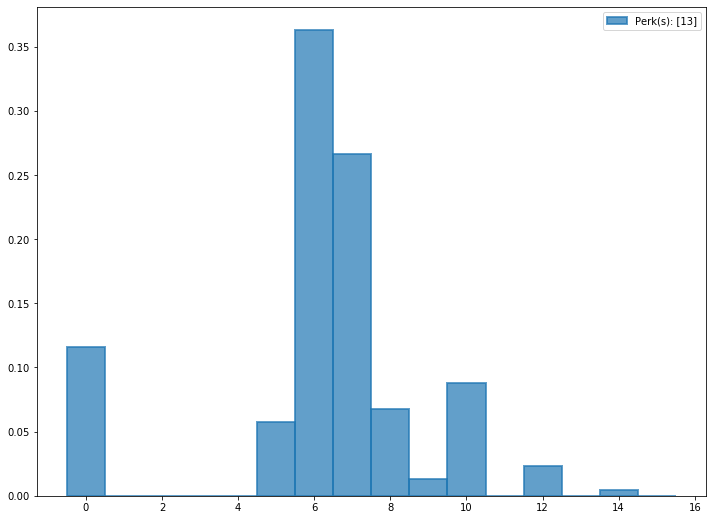

In [563]:
fig, ax = plt.subplots( figsize=(12,9))

base_attack=5
for ii,p in enumerate([[13]]):
    d = Scoundrel(base_attack)
    #d.add_bless(2)
    d.add_perk([0,1,2,3,4,5,6,7,8,9,10,11,12])
    d.add_perk(p)
    sample = d.draw(100000)
    display(d.card_instances)
    values = get_values(sample, d.base_attack)
    shuffle = get_shuffled(sample)
    print('Perk(s): {}'.format(p))
    print('mean: {:.2}\nvariance: {:.2}'.format(np.mean(values), np.var(values)))
    shuffle_pos = np.array(list(shuffle.keys()))
    print('Expected turns until reshuffle: {:.2}'.format(np.mean(shuffle_pos[1:]-shuffle_pos[:-1])))

    turnlength = np.mean(get_turnlength(sample))
    print('Expected modifier cards per turn: {:.2}\n'.format(turnlength))

    #ax[ii//2, np.mod(ii,2)].hist(values, density=True, bins=np.linspace(-0.5,2*(d.base_attack+2)+0.5,2*d.base_attack+6), alpha=0.6);
    #ax[ii//2, np.mod(ii,2)].set_xlabel('Perk: {} {} {} {}'.format(d.perks[p].action, d.perks[p].number, d.perks[p].card, d.perks[p].repcard))
    ax.hist(values, density=True, bins=np.linspace(-0.5,2*(d.base_attack+2)+1.5,2*d.base_attack+7),edgecolor='C{}'.format(ii), lw=2, alpha=0.7, label=('Perk(s): {}'.format(p)));
    ax.legend()

# Brute

{'miss': 1,
 'crit': 1,
 '-2': 1,
 '-1': 0,
 '0': 6,
 '1': 10,
 '2': 1,
 '3': 1,
 'pierce3': 2,
 'push1': 6,
 'stun': 2,
 'add_target': 2,
 'disarm': 1,
 'muddle': 1,
 'shield1': 1}

Perk(s): [1]
mean: 5.6
variance: 4.1
Expected turns until reshuffle: 7.6
Expected modifier cards per turn: 1.6



{'miss': 1,
 'crit': 1,
 '-2': 1,
 '-1': 0,
 '0': 2,
 '1': 10,
 '2': 1,
 '3': 1,
 'pierce3': 2,
 'push1': 6,
 'stun': 2,
 'add_target': 2,
 'disarm': 1,
 'muddle': 1,
 'shield1': 1}

Perk(s): [1, 15]
mean: 5.7
variance: 4.9
Expected turns until reshuffle: 6.4
Expected modifier cards per turn: 1.7



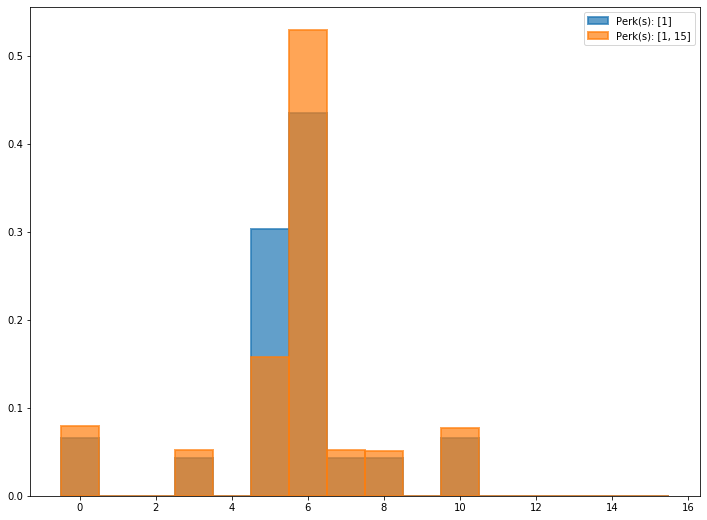

In [568]:
fig, ax = plt.subplots( figsize=(12,9))
#d = Brute(base_attack)

base_attack=5
for ii,p in enumerate([[1], [1,15]]):
    d = Brute(base_attack)
    #d.add_bless(1)
    d.add_perk([0,2,3,4,5,6,7,8,9,10,11,12,13,14])
    d.add_perk(p)
    sample = d.draw(100000)
    display(d.card_instances)
    values = get_values(sample, d.base_attack)
    shuffle = get_shuffled(sample)
    print('Perk(s): {}'.format(p))
    print('mean: {:.2}\nvariance: {:.2}'.format(np.mean(values), np.var(values)))
    shuffle_pos = np.array(list(shuffle.keys()))
    print('Expected turns until reshuffle: {:.2}'.format(np.mean(shuffle_pos[1:]-shuffle_pos[:-1])))

    turnlength = np.mean(get_turnlength(sample))
    print('Expected modifier cards per turn: {:.2}\n'.format(turnlength))

    #ax[ii//2, np.mod(ii,2)].hist(values, density=True, bins=np.linspace(-0.5,2*(d.base_attack+2)+0.5,2*d.base_attack+6), alpha=0.6);
    #ax[ii//2, np.mod(ii,2)].set_xlabel('Perk: {} {} {} {}'.format(d.perks[p].action, d.perks[p].number, d.perks[p].card, d.perks[p].repcard))
    ax.hist(values, density=True, bins=np.linspace(-0.5,2*(d.base_attack+2)+1.5,2*d.base_attack+7),edgecolor='C{}'.format(ii), lw=2, alpha=0.7, label=('Perk(s): {}'.format(p)));
    ax.legend()